# 初始化

In [25]:
!nvidia-smi

Fri Feb 28 07:55:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P0             34W /  250W |     267MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import os
from tqdm import trange

# 生成射线

In [27]:
# 生成的射线仅有相机自身的内参和外参有关，和图片本身是什么颜色无关
def get_rays(H, W, focal, c2w):
  '''
  c2w = [ R_3x3, t_3x1
      0_1x3, 1    ]
  前3行3列表示旋转
  t表示平移
  '''
  i, j = torch.meshgrid(torch.linspace(0, W-1, W), torch.linspace(0, H-1, H))  # pytorch's meshgrid has indexing='ij'
  i = i.t()
  j = j.t()
  # 除以焦距归一化 参见https://www.youtube.com/watch?v=ujkec9KBnI8
  dirs = torch.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -torch.ones_like(i)], -1).to(c2w)
  # [3,3] * [H, W, 1, 3] 对应元素相乘，再求和 <=> c2w @ dir in dirs
  rays_d = torch.sum(dirs.unsqueeze(-2) * c2w[:3,:3], -1)
  # 转换为方向向量
  rays_d = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
  # Translate camera frame's origin to the world frame. It is the origin of all rays.
  rays_o = c2w[:3,-1].expand(rays_d.shape)
  return rays_o, rays_d

def get_rays_v2(H, W, focal, c2w):
    # 1. 先构建固定的相机坐标
    xs = torch.arange(W) - (W/2 - 0.5)
    ys = torch.arange(H) - (H/2 - 0.5)
    (xs, ys) = torch.meshgrid(xs, -ys, indexing="xy")  # 注意这里用-ys

    # 2. 归一化到相机坐标系
    camera_coords = torch.stack([
        xs/focal,
        ys/focal,
        -torch.ones_like(xs)
    ], dim=-1).to(c2w)

    # 3. 设置固定原点
    camera_origin = torch.Tensor([0, 0, float(data["camera_distance"])]).to(c2w)

    # 4. 通过变换矩阵转换到世界坐标系
    R = c2w[:3,:3]
    rays_d = torch.einsum("ij,hwj->hwi", R, camera_coords)
    rays_o = (R @ camera_origin).expand(rays_d.shape)

    return rays_o, rays_d

# 采样
获得粗采样和细采样点的深度

In [28]:
# 注意，r = o + t*d，其中d需要是方向向量
def get_coarse_query_pts(rays_o, rays_d ,N_c, t_edges, t_gap):
  '''
  t_edges [1,N_c]
  t_gap float
  rays_o,rays_d [H,W,3]
  '''

  u = torch.rand([*rays_d.shape[:2], N_c]).to(rays_d) # [H,W,N_c] to可以保持跟rays_d一样的数据类型和设备类型
  t = t_edges + u * t_gap # [H,W,N_c]
  # r = o + t*d
  r = rays_o.unsqueeze(-2) + t.unsqueeze(-1) * rays_d.unsqueeze(-2) # [H,W,N_c,3]
  # r是t对应位置的坐标,即射线上点的坐标
  # t是距离，即射线上点到射线原点的距离
  return r, t

def get_fine_query_pts(rays_o, rays_d ,N_f, weights, t):
  '''
  weights [H,W,N_c]
  '''
  weights = weights + 1e-5 # 小心这里不要用+=，这是inplace operation，可能会梯度计算出错
  pdf = weights / torch.sum(weights, -1, keepdim=True)
  cdf = torch.cumsum(pdf, -1)
  # 获得初始概率为0的分布函数
  cdf = torch.cat([torch.zeros_like(cdf[..., :1]), cdf[..., :-1]], -1) # [H,W,N_c]

  # u和cdf对应的都是概率
  u = torch.rand([*rays_d.shape[:-1],N_f]).to(weights) # [H,W,N_f]，每条射线都有N_f个精细采样点等待放置
  idxs = torch.searchsorted(cdf, u, right=True) # u<=cdf的最后一个索引

  # F(t) = cdf，其中t和cdf是按照索引对应的
  # 那么u-cdf-t，可以如此找到对应的t
  # u会被放置在对应的区间[t_fine_left,t_fine_right]内
  t_fine_left = torch.gather(t, -1, idxs-1)

  # 防止索引越界
  idxs_capped = idxs.clone()
  max_idx = cdf.shape[-1]

  idxs_capped[idxs_capped == max_idx] = max_idx - 1

  t_fine_right = torch.gather(t, -1, idxs_capped)

  t_gaps = t_fine_right - t_fine_left

  # 得到上下界t对应的cdf
  # 参见https://github.com/bmild/nerf/issues/151
  cdf_left = torch.gather(cdf, -1, idxs-1)
  cdf_right = torch.gather(cdf, -1, idxs_capped)
  cdf_gaps = cdf_right - cdf_left
  cdf_gaps = torch.where(cdf_gaps < 1e-5, torch.ones_like(t_gaps), cdf_gaps) # 如果区间的差距太小就默认设置成1，防止变成inf
  t_fine = (u-cdf_left)/cdf_gaps + t_fine_left # [H,W,N_f]

  # 将粗采样点和细采样点放在一起
  t_c_f = torch.cat([t, t_fine], -1)
  t_c_f,_ = torch.sort(t_c_f ,dim=-1) # [H,W,N_c+N_f]
  r = rays_o.unsqueeze(-2) + t_c_f.unsqueeze(-1) * rays_d.unsqueeze(-2) # [num_rays, N_c+N_f, 3]

  return r, t_c_f

# 体渲染

In [29]:
def render(r, t, rays_d, chunk_size, F):
  # r [H,W,N_samples,3]
  # t [H,W,N_samples]
  # rays_d需要是方向向量 [H,W,3]
  # F是网络

  N_samples = r.shape[-2]
  r_flat = r.reshape(-1,3)
  rays_d = rays_d.unsqueeze(2).repeat(1, 1, N_samples, 1)
  rays_d_flat = rays_d.reshape(-1,3)


  colors = []
  density = []

  # 分批加入网络，防止out of memoray
  for i in range(0, r_flat.shape[0], chunk_size):
    r_chunk = r_flat[i:i+chunk_size]
    rays_d_chunk = rays_d_flat[i:i+chunk_size]
    preds = F(r_chunk, rays_d_chunk)
    colors.append(preds['color'])
    density.append(preds['density'])

  colors = torch.cat(colors, 0).reshape(r.shape) # [H,W,N_samples,3]
  density = torch.cat(density, 0).reshape(r.shape[:-1]) # [H,W,N_samples]

  # 渲染
  delta = torch.cat([t[..., 1:] - t[..., :-1], torch.ones_like(t[..., :1]) * 1e10], -1)
  alpha = 1. - torch.exp(-density * delta)
  # T_i = 1-alpha_i从1连乘到i-1
  # i显然不能取1，i=1的时候默认就T_1取1
  T = torch.cumprod(torch.cat([torch.ones_like(alpha[..., :1]), 1. - alpha + 1e-10], -1), -1)[..., :-1]
  weights = alpha * T # [H,W,N_samples]

  # 沿着距离轴/样点轴，来求和/积分
  C = torch.sum(weights.unsqueeze(-1) * colors, -2)
  return C, weights

## 运行1轮NeRF从光线得到颜色


In [30]:
def run_one_iter_of_nerf(
    rays_o, rays_d, t_edges, t_gap, N_c, N_f, chunk_size, F_c, F_f
):
  r_c, t_c = get_coarse_query_pts(rays_o, rays_d, N_c, t_edges, t_gap) # 得到粗采样点的坐标和深度
  C_c, w_c = render(r_c, t_c, rays_d, chunk_size, F_c) # 渲染粗采样点

  r_c_f, t_c_f = get_fine_query_pts(rays_o, rays_d, N_f, w_c, t_c) # 获得所有的采样点，即粗采样点+戏采样点
  C_f, _ = render(r_c_f, t_c_f, rays_d, chunk_size, F_f) # 最终渲染

  return C_c, C_f

# NeRF架构

In [31]:
class NeRF(nn.Module):
  def __init__(self) -> None:
    super().__init__()

    # 位置编码的映射维度
    self.L_pts = 10 # 空间位置的坐标的编码 point
    self.L_dir = 4 # 方向/rays_d的坐标的编码 direction
    # 编码后的维度 = 自身维度 + 嵌入函数的个数*（自身维度*L）
    # 这里的嵌入函数是sin和cos两个
    pts_dim = 3 + 2 * (3 * self.L_pts) # = 63
    dirs_dim = 3 + 2 * (3 * self.L_dir) # = 27

    input_dim = pts_dim
    net_width = 256

    # 参见NeRF原文最后的Additional Implementation Details
    # 0-4号层是早期的普通线性层
    num_early_layers = 5
    early_mlp = []
    for i in range(num_early_layers):
      early_mlp.append(nn.Linear(input_dim, net_width))
      early_mlp.append(nn.ReLU())
      input_dim = net_width
    self.early_mlp = nn.Sequential(*early_mlp)

    # 后期线性层，5-7号层
    # 注意这一层的输入要再嵌入初始的输入
    input_dim = pts_dim + net_width
    num_late_layers = 3
    late_mlp = []
    for i in range(num_late_layers):
      late_mlp.append(nn.Linear(input_dim, net_width))
      late_mlp.append(nn.ReLU())
      input_dim = net_width
    self.late_mlp = nn.Sequential(*late_mlp)

    # 8号层
    # 注意这一层没有激活函数，输出的密度需要经过relu使之非负
    self.density_layer = nn.Linear(net_width, net_width + 1) # 这里的1就是输出的密度

    # 9号层
    # 注意这一层的输入要拼接dirs
    self.pre_final_layer = nn.Sequential(
        nn.Linear(dirs_dim + net_width, net_width // 2), # 256->128
        nn.ReLU()
    )

    # 10号rgb层
    self.final_layer = nn.Sequential(
        nn.Linear(net_width // 2, 3), # 128->3
        nn.Sigmoid()
    )

  def forward(self, pts, dirs):
    # 位置编码

    # 点坐标的编码
    pts_encoded = [pts]

    # 论文里有乘pi，但是作者的代码里没有乘。原因参见https://github.com/bmild/nerf/issues/12
    # 计算的是所有点的第i个编码特征的值
    for i in range(self.L_pts):
      pts_encoded.append(torch.sin(2 ** i * torch.pi * pts))
      pts_encoded.append(torch.cos(2 ** i * torch.pi * pts))
    pts_encoded = torch.cat(pts_encoded, dim=-1)
    # print(pts_encoded.shape)

    # 方向的编码
    dirs = dirs / torch.norm(dirs, dim=-1, keepdim=True)
    dirs_encoded = [dirs]
    for i in range(self.L_dir):
      dirs_encoded.append(torch.sin(2 ** i * torch.pi * dirs))
      dirs_encoded.append(torch.cos(2 ** i * torch.pi * dirs))
    dirs_encoded = torch.cat(dirs_encoded, dim=-1)
    # print(dirs_encoded.shape)


    # 前向
    outputs = self.early_mlp(pts_encoded)
    outputs = self.late_mlp(torch.cat([pts_encoded, outputs], dim=-1))
    outputs = self.density_layer(outputs) # 注意这一层没有激活函数
    density = torch.relu(outputs[:, 0])

    outpts = self.pre_final_layer(torch.cat([dirs_encoded, outputs[:, 1:]], dim=-1))
    color = self.final_layer(outpts)
    return {"color": color, "density": density}

# 训练模型

## 初始化模型参数

In [32]:
# Set seed.
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Initialize coarse and fine MLPs.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
F_c = NeRF().to(device)
F_f = NeRF().to(device)
# Number of query points passed through the MLP at a time. See: https://github.com/bmild/nerf/blob/18b8aebda6700ed659cb27a0c348b737a5f6ab60/run_nerf.py#L488.
chunk_size = 1024 * 32
# Number of training rays per iteration. See Section 5.3.
batch_img_size = 64
n_batch_pix = batch_img_size ** 2

# Initialize optimizer. See Section 5.3.
lr = 5e-4
optimizer = optim.Adam(list(F_c.parameters()) + list(F_f.parameters()), lr=lr)
criterion = nn.MSELoss()
# The learning rate decays exponentially. See Section 5.3
# See: https://github.com/bmild/nerf/blob/18b8aebda6700ed659cb27a0c348b737a5f6ab60/run_nerf.py#L486.
lrate_decay = 250
decay_steps = lrate_decay * 1000
# See: https://github.com/bmild/nerf/blob/18b8aebda6700ed659cb27a0c348b737a5f6ab60/run_nerf.py#L707.
decay_rate = 0.1


## 导入数据

In [ ]:
# 导入lego数据集

if not os.path.exists('lego.npz'):
  !wget "http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz" -O lego.npz
if not os.path.exists('car.npz'):
  !wget "https://github.com/airalcorn2/pytorch-nerf/blob/master/66bdbc812bd0a196e194052f3f12cb2e.npz?raw=True" -O car.npz

# lego or car
data_f = "lego_train_val.npz"
data = np.load(data_f)

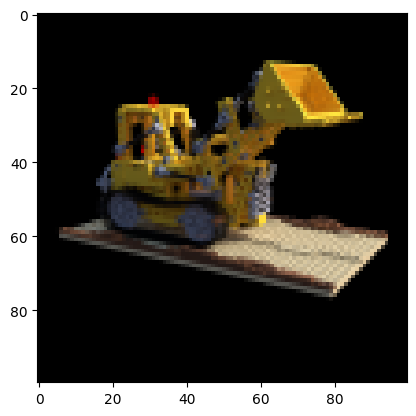

In [34]:

# 像素平面在成像平面下的坐标是固定的，与相机位姿是无关的
'''
     ↑y
 →u    →x
↓v
'''
images = torch.tensor(data["images"].astype(np.float32))
if data_f == "car.npz":
  images = images/255
poses = torch.tensor(data["poses"].astype(np.float32))
focal = float(data['focal'])
# img_size = images.shape[1]
H, W = images.shape[1:3]

# 选择一张用来显示训练效果的图（图与位姿是一一对应的，从不同的位姿观察3D模型会产生不同的2D视图）
test_idx = 10
plt.imshow(images[test_idx])
plt.show()
test_img = torch.Tensor(images[test_idx]).to(device)

test_os, test_ds = get_rays(H, W, focal, poses[test_idx])
test_os = test_os.to(device) # [H, W, 3]
test_ds = test_ds.to(device)

## 初始化体渲染参数

In [35]:
# Initialize volume rendering hyperparameters.
# Near bound. See Section 4.
t_n = 1.0
# Far bound. See Section 4.
t_f = 4.0
# Number of coarse samples along a ray. See Section 5.3.
N_c = 64
# Number of fine samples along a ray. See Section 5.3.
N_f = 128
# Bins used to sample depths along a ray. See Equation (2) in Section 4.
t_i_c_gap = (t_f - t_n) / N_c
t_i_c_bin_edges = (t_n + torch.arange(N_c) * t_i_c_gap).to(device)

## 训练

In [36]:
# Start training model.
train_idxs = np.arange(len(images)) != test_idx
images = images[train_idxs]
poses = poses[train_idxs]
n_pix = H*W # 一张图总的像素数量

# 一个长为H*W，值为1/(H*W)的概率向量
pixel_ps = torch.full((n_pix,), 1 / n_pix).to(device)
psnrs = []
iternums = []
# See Section 5.3.
global_step = 0
num_iters = 100000
display_every = 100
weight_every = 100
model_path = './model' # 训练模型的状态目录

if os.path.exists(model_path) == False:
  os.mkdir(model_path)

# 检查点读取
LOAD_ckpts = True
if LOAD_ckpts:
  ckpts = [os.path.join(model_path,f) for f in sorted(os.listdir(model_path)) if 'tar' in f]
  # 升序排列，选择最后一轮开始训练
  if len(ckpts)>0:
    print('Found ckpts',f'-->{ckpts}')
    checkpoint = torch.load(ckpts[-1], weights_only=False)
    F_c.load_state_dict(checkpoint['model_coarse_state_dict'])
    F_f.load_state_dict(checkpoint['model_fine_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    global_step = checkpoint['global_step'] + 1
    psnrs = checkpoint['psnrs']
    iternums = checkpoint['iternums']
  else:
    print('No ckpts found')
    print('Train from scratch')

F_c.train()
F_f.train()

for i in trange(global_step, num_iters):
    # 从训练集中随机选一个位姿
    target_img_idx = np.random.randint(images.shape[0])
    target_pose = poses[target_img_idx].to(device)
    rays_o, rays_d = get_rays(H, W, focal, target_pose)

    # Sample a batch of rays.
    # 不放回的抽样，从pixel_ps的分布中抽出n_batch_pix个样本
    # 换言之，从所有的像素中抽出n_batch_pix个像素
    pix_idxs = pixel_ps.multinomial(n_batch_pix, False)
    # 将展平后的一维索引转换成原图片的二维索引
    pix_idx_rows = pix_idxs // W
    pix_idx_cols = pix_idxs % W

    # n_batch_pix = batch_img_size ** 2
    ds_batch = rays_d[pix_idx_rows, pix_idx_cols].reshape(
        batch_img_size, batch_img_size, -1
    )
    os_batch = rays_o[pix_idx_rows, pix_idx_cols].reshape(
        batch_img_size, batch_img_size, -1
    )

    # Run NeRF.
    (C_rs_c, C_rs_f) = run_one_iter_of_nerf(
        os_batch,
        ds_batch,
        t_i_c_bin_edges,
        t_i_c_gap,
        N_c,
        N_f,
        chunk_size,
        F_c,
        F_f,
    )
    target_img = images[target_img_idx].to(device)
    target_img_batch = target_img[pix_idx_rows, pix_idx_cols].reshape(C_rs_f.shape)
    # Calculate the mean squared error for both the coarse and fine MLP models and
    # update the weights. See Equation (6) in Section 5.3.
    loss = criterion(C_rs_c, target_img_batch) + criterion(C_rs_f, target_img_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Exponentially decay learning rate. See Section 5.3 and:
    # https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/.
    for g in optimizer.param_groups:
        g["lr"] = lr * decay_rate ** (i / decay_steps)


    if i % display_every == 0 and i > 0:
        F_c.eval()
        F_f.eval()
        with torch.no_grad():
            (_, C_rs_f) = run_one_iter_of_nerf(
                test_os,
                test_ds,
                t_i_c_bin_edges,
                t_i_c_gap,
                N_c,
                N_f,
                chunk_size,
                F_c,
                F_f,
            )

        loss = criterion(C_rs_f, test_img)
        print(f"Loss: {loss.item()}")
        psnr = -10.0 * torch.log10(loss)

        psnrs.append(psnr.item())
        iternums.append(i)

        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(C_rs_f.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title("PSNR")
        plt.show()

        F_c.train()
        F_f.train()

    # 存储模型，check points 检查点
    if i % weight_every == 0 and i > 0:
      path = os.path.join(model_path, '{:06d}.tar'.format(i))
      torch.save(
            {
                "model_coarse_state_dict": F_c.state_dict(),
                "model_fine_state_dict": F_f.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                'global_step': i,
                'psnrs': psnrs,
                'iternums': iternums,
            },
            path,
          )

print("Done!")

Found ckpts -->['./model/001000.tar', './model/002000.tar', './model/003000.tar', './model/004000.tar']


OSError: [Errno 22] Invalid argument